In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('avg_salary.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Period      4416 non-null   float64
 1   Position    4416 non-null   object 
 2   Seniority   4416 non-null   object 
 3   Global_exp  2688 non-null   object 
 4   Local_exp   3335 non-null   object 
 5   Salary      4416 non-null   int64  
 6   GDP         4416 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 241.6+ KB


In [4]:
df.head()

,Period,Position,Seniority,Global_exp,Local_exp,Salary,GDP
0,2019.06,Business analyst,Junior,0.5,4,850,3619.861572
1,2019.06,Business analyst,Middle,2,меньше 3 месяцев,1200,3619.861572
2,2019.06,Business analyst,Junior,0.5,0.5,950,3619.861572
3,2019.06,Business analyst,Junior,1.5,1.5,650,3619.861572
4,2019.06,Business analyst,Middle,2,2,1400,3619.861572


In [5]:
df.dtypes

Period        float64
Position       object
Seniority      object
Global_exp     object
Local_exp      object
Salary          int64
GDP           float64
dtype: object

In [6]:
df.shape

(4416, 7)

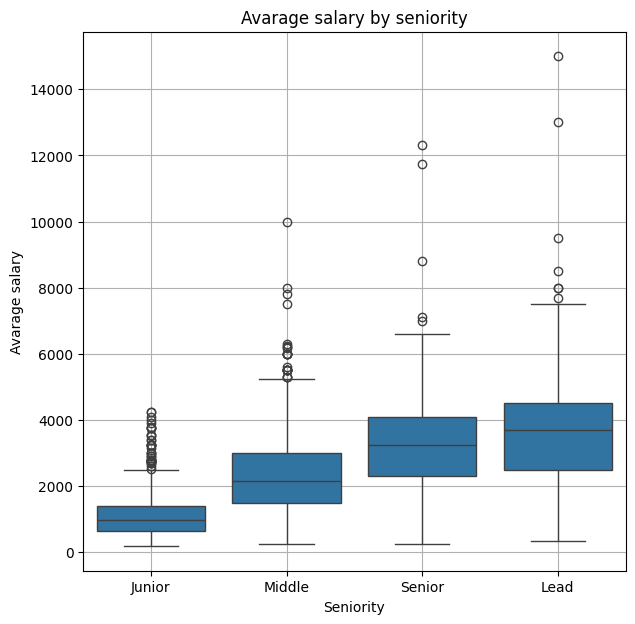

In [49]:
plt.figure(figsize=(7, 7))
sns.boxplot(df, x='Seniority', y = 'Salary', order = df.groupby('Seniority')['Salary'].mean().sort_values().index)
plt.title('Avarage salary by seniority')
plt.ylabel('Avarage salary')
plt.grid()
plt.show()

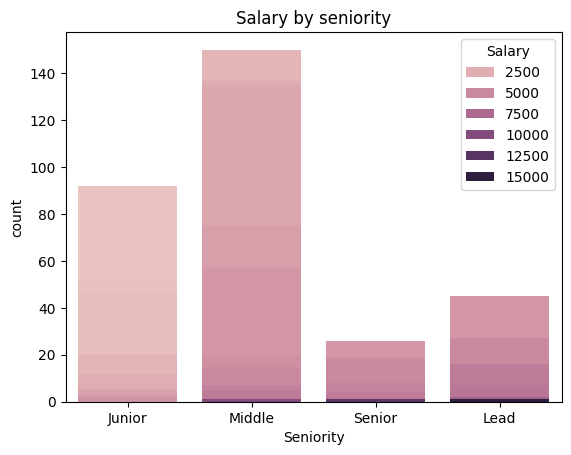

In [47]:
sns.countplot(x = df['Seniority'], hue = df['Salary'], dodge = False, order = df.groupby('Seniority')['Salary'].mean().sort_values().index, saturation = 1.5)
plt.title('Salary by seniority')
plt.show()

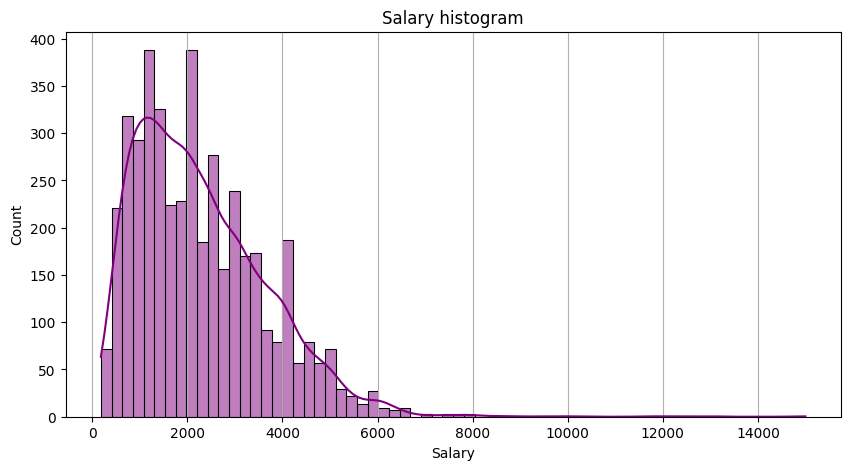

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins = 'auto', kde= True, color = 'purple', edgecolor = 'black')
plt.title('Salary histogram')
plt.grid(axis = 'x')
plt.show()

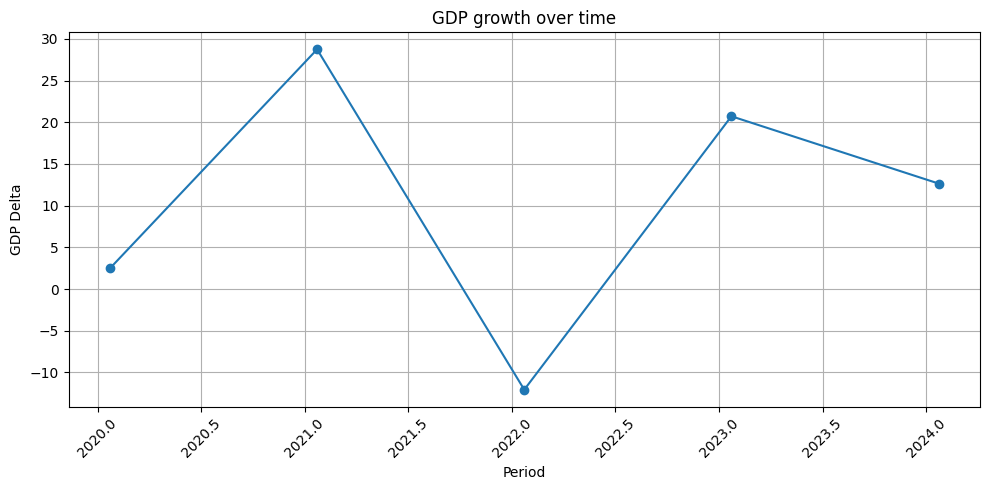

In [45]:
df_gdp = df[['Period', 'GDP']].drop_duplicates().sort_values('Period')
df_gdp = df_gdp[df_gdp['Period'].astype(str).str.endswith('.06')]
df_gdp['GDP Delta%'] = df_gdp['GDP'].pct_change() * 100
plt.figure(figsize=(10, 5))
plt.plot(df_gdp['Period'], df_gdp['GDP Delta%'], marker = 'o', linestyle = '-')
plt.title('GDP growth over time')
plt.xlabel('Period')
plt.ylabel('GDP Delta')
plt.xticks(rotation = 45)
plt.grid()
plt.tight_layout()
plt.show()